# Roberta  
In this experiment, we will train the model using the entire training dataset, ensuring there is enough data for the model to learn from. After training, we will review the results, and we expect to see some improvement in the performance.

In [ ]:
%%capture
!pip install mlflow dagshub wandb

In [ ]:
# Standard Library Imports
import math
import os
from typing import Dict, List

# Third-party Libraries
import mlflow
import mlflow.pytorch
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from torch.optim import AdamW, RMSprop, SGD
from torch.utils.data import DataLoader, Dataset
from wordcloud import WordCloud

# Hugging Face Transformers
from transformers import (
    AdamW,
    AutoModel,
    AutoTokenizer,
    BertModel,
    BertTokenizer,
    get_linear_schedule_with_warmup
)

# PyTorch Libraries
import torch.nn as nn
import torch.nn.functional as F


# import google drive
from google.colab import drive, files
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""Import the modules from google colab"""
import sys
PATH_helper = "/content/drive/MyDrive/turing_college_experiments/16/helper"
sys.path.append(PATH_helper)
# Custom imports
from helper_eda import (proportion_balance_classes, extractions_text_description, histogram_bins,
                                plot_distribution_tokens_per_word, dimensionality_reduction_chart_tsne,
                               components_pca_3d_chart)
from helper_model import (CustomDataset, custom_collate_fn, pytorch_metrics_calculations, train_model, evaluate_model)

"""
Verify the cores and gpu in the colab
"""
num_cores = os.cpu_count()  # Get the number of CPU cores
print(f'Number of available CPU cores: {num_cores}')
NUM_WORKERS = num_cores - 1
print(f'Setting num_workers to: {NUM_WORKERS}')

num_gpus_colab = torch.cuda.device_count()
GPU_LIST = [torch.cuda.get_device_name(i) for i in range(num_gpus_colab)]
NUM_WORKERS, GPU_LIST

enable_code_paths = True
enable_block = False

# weight and biases
wandb.login()

# ml versioning control
import dagshub
import mlflow
import mlflow.sklearn
dagshub.init(repo_owner='auszed', repo_name='Experiments_fake_news', mlflow=True)

# tracking experiments
os.environ['MLFLOW_TRACKING_USERNAME'] = 'auszed'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4390ce1796189f46f62a5e643463dcaffede3ebf'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/auszed/Experiments_fake_news.mlflow'


# Download the stopwords if you haven't already
nltk.download('stopwords')

# Inline plotting for Jupyter Notebooks
%matplotlib inline
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)

# File paths
X_train = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_train_cleaned_2.csv")
y_train = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_train.csv")
X_val = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_val_cleaned_2.csv")
y_val = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_val.csv")
X_test = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_test_cleaned_2.csv")
y_test = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_test.csv")

X_train = X_train[["title_text_join"]]
X_val = X_val[["title_text_join"]]
X_test = X_test[["title_text_join"]]

print(X_train.shape,y_train.shape )
print(X_val.shape,y_val.shape )
print(X_test.shape,y_test.shape )
theme_color

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of available CPU cores: 12
Setting num_workers to: 11


Initialized MLflow to track repo "auszed/Experiments_fake_news"

Repository auszed/Experiments_fake_news initialized!

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(26759, 1) (26759, 1)
(5734, 1) (5734, 1)
(5735, 1) (5735, 1)


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [ ]:
#@title sample dataset for experiments
# sample size
enable_samples: bool = True #@param
SAMPLE_PERCENTAGE_X_train = 1 #@param
SAMPLE_PERCENTAGE_X_val = 1 #@param
SAMPLE_PERCENTAGE_X_test = 1 #@param

MODEL_NAME = "roberta-base" #@param
VERSION_MODEL = "010" #@param
NAME_EXPERIMENTS = "Fake news comments" #@param
DATASET_NAME = "X_train_cleaned_2" #@param title
HYPERPARAMETERS_EXPERIMENTS = 1 #@param
BATCH_SIZE = 8 #@param
NUM_LABELS = 1 #@param
EPOCHS = 3 #@param
THRESHOLD_PROBABILITIES_MODEL = 0.5 #@param
MAX_TOKENS = 512 #@param

# COMMENTS = "Some hyperparameter tunning with the clean dataset where we take out some values" #@param
COMMENTS = "Update of the model full training" #@param
# PATIENCE_EARLY_STOP = 3 #@param
LEARNING_RATE = 0.002500000075 #@param
WEIGHT_DECAY = 0.01 #@param
DROPOUT_VALUE = 0.139164305582066 #@param
WARMUP_RATIO = 0.192605760830724 #@param
OPTIMIZER_NAME = "AdamW" #@param


URL_SAVE_MODEL = f"/content/drive/MyDrive/turing_college_experiments/16/model_save/{MODEL_NAME}_{VERSION_MODEL}.pth"

if enable_samples:
    # Concatenating the datasets
    concat_values_train = pd.concat([X_train, y_train], axis=1)
    concat_values_val = pd.concat([X_val, y_val], axis=1)
    concat_values_test = pd.concat([X_test, y_test], axis=1)

    # Sampling the datasets
    concat_values_train = concat_values_train.sample(frac=SAMPLE_PERCENTAGE_X_train, random_state=42)
    concat_values_val = concat_values_val.sample(frac=SAMPLE_PERCENTAGE_X_val, random_state=42)
    concat_values_test = concat_values_test.sample(frac=SAMPLE_PERCENTAGE_X_test, random_state=42)

    # Resetting the index without using inplace
    concat_values_train = concat_values_train.reset_index(drop=True)
    concat_values_val = concat_values_val.reset_index(drop=True)
    concat_values_test = concat_values_test.reset_index(drop=True)

    # Extracting features and targets
    X_train = pd.DataFrame(concat_values_train["title_text_join"])
    X_val = pd.DataFrame(concat_values_val["title_text_join"])
    X_test = pd.DataFrame(concat_values_test["title_text_join"])

    y_train = pd.DataFrame(concat_values_train["target_variable"])
    y_val = pd.DataFrame(concat_values_val["target_variable"])
    y_test = pd.DataFrame(concat_values_test["target_variable"])


print("TRAIN Dataset: {}".format(X_train.shape))
print("VALIDATION Dataset: {}".format(X_val.shape))
print("TEST Dataset: {}".format(X_test.shape))
print("TRAIN Dataset y: {}".format(y_train.shape))
print("VALIDATION Dataset y: {}".format(y_val.shape))
print("TEST Dataset y: {}".format(y_test.shape))

sample_data = 5 #@param
X_train.sample(sample_data)

TRAIN Dataset: (26759, 1)
VALIDATION Dataset: (5734, 1)
TEST Dataset: (5735, 1)
TRAIN Dataset y: (26759, 1)
VALIDATION Dataset y: (5734, 1)
TEST Dataset y: (5735, 1)


,title_text_join
2166,fox news ’ james rosen : “ sheer scale ” spyin...
16203,taiwan allow visa free entry visitors philippi...
23080,fbi found related emails devices belonging aid...
2848,iraq declare final victory islamic state deser...
18351,london life laid bare rubbish along thameslond...


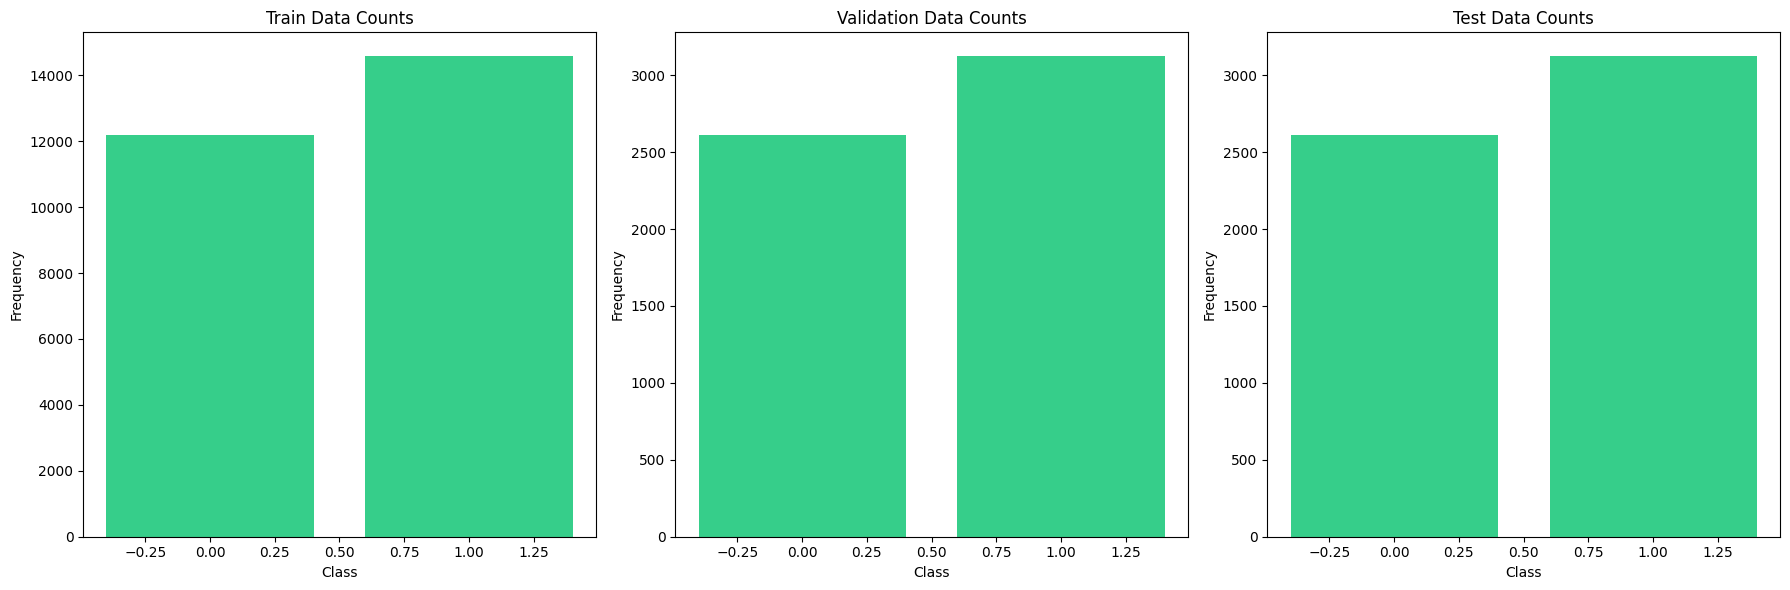

In [ ]:
#@title Split of the dataset
# Get counts for each dataset
train_counts = y_train.value_counts().reset_index()
val_counts = y_val.value_counts().reset_index()
test_counts = y_test.value_counts().reset_index()
train_counts.columns = ['Class', 'Frequency']
val_counts.columns = ['Class', 'Frequency']
test_counts.columns = ['Class', 'Frequency']

real_values = train_counts['Frequency'][0]
fake_values = train_counts['Frequency'][1]
total_values = train_counts['Frequency'].sum()
real_percentage = (real_values / total_values)
fake_percentage = (fake_values / total_values)

normalized_weights = torch.tensor([real_percentage, fake_percentage], dtype=torch.float)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot for train data
ax[0].bar(train_counts['Class'], train_counts['Frequency'])
ax[0].set_title('Train Data Counts')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')

# Plot for validation data
ax[1].bar(val_counts['Class'], val_counts['Frequency'])
ax[1].set_title('Validation Data Counts')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

# Plot for test data
ax[2].bar(test_counts['Class'], test_counts['Frequency'])
ax[2].set_title('Test Data Counts')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
#@title Dataloader
# Model configuration
model_name = MODEL_NAME
tokenizer_model = AutoTokenizer.from_pretrained(model_name)

# dataloaders for training, val, test
dataset_loader_X_train = CustomDataset(
    dataframe=X_train,
    comment_str_title='title_text_join',
    target_variable=y_train,
    tokenizer=tokenizer_model,
    max_token_len=MAX_TOKENS
)
dataset_loader_X_val = CustomDataset(
    dataframe=X_val,
    comment_str_title='title_text_join',
    target_variable=y_val,
    tokenizer=tokenizer_model,
    max_token_len=MAX_TOKENS
)
dataset_loader_X_test = CustomDataset(
    dataframe=X_test,
    comment_str_title='title_text_join',
    target_variable=y_test,
    tokenizer=tokenizer_model,
    max_token_len=MAX_TOKENS
)

# Test the dataset
print("Dataset train length:", len(dataset_loader_X_train))
print("Dataset val length:", len(dataset_loader_X_val))
print("Dataset test length:", len(dataset_loader_X_test))
sample = dataset_loader_X_train[0]
print("Sample input IDs shape:", sample["input_ids"].shape)
print("Sample attention masks shape:", sample["attention_masks"].shape)
print("Sample labels:", sample["labels"])


Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


Dataset train length: 26759
Dataset val length: 5734
Dataset test length: 5735
Sample input IDs shape: torch.Size([3, 512])
Sample attention masks shape: torch.Size([3, 512])
Sample labels: tensor([1.])


In [ ]:
#@title Batches

# Create DataLoader with custom collate function
train_loader = DataLoader(
    dataset=dataset_loader_X_train,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,  # Adjust based on your CPU cores
    pin_memory=True,  # Set to True if using GPU
    drop_last=True
)
val_loader = DataLoader(
    dataset=dataset_loader_X_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)
test_loader = DataLoader(
    dataset=dataset_loader_X_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

print(len(train_loader), "train_loader batch")
print(len(val_loader), "val_loader batch")
print(len(test_loader), "test_loader batch")

3344 train_loader batch
716 val_loader batch
716 test_loader batch


In [ ]:
#@title Model architecture

class ClassifierModel(nn.Module):
    def __init__(self, config):
        super(ClassifierModel, self).__init__()
        self.config = config

        # Pretrained model
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)

        # Layers
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classification = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])

        # Initialize weights
        nn.init.xavier_uniform_(self.hidden.weight)  # Use Xavier initialization
        nn.init.zeros_(self.hidden.bias)  # Initialize bias to zero
        nn.init.xavier_uniform_(self.classification.weight)  # Use Xavier initialization
        nn.init.zeros_(self.classification.bias)  # Initialize bias to zero

        # Loss function
        # self.loss_function = nn.BCEWithLogitsLoss(weight=normalized_weights)
        self.loss_function = nn.BCEWithLogitsLoss()

        # Dropout
        self.dropout = nn.Dropout(config['dropout_vals'])

    def forward(self, input_ids, attention_mask, chunk_attention_mask=None):
        batch_size, num_chunks, seq_length = input_ids.size()
        input_ids = input_ids.view(-1, seq_length)
        attention_mask = attention_mask.view(-1, seq_length)

        # Forward pass through the pretrained model
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        pooled_output = pooled_output.view(batch_size, num_chunks, -1)
        pooled_output = self.dropout(pooled_output)

        if chunk_attention_mask is not None:
            chunk_attention_mask = chunk_attention_mask.float().unsqueeze(-1)
            pooled_output = (pooled_output * chunk_attention_mask).sum(dim=1) / chunk_attention_mask.sum(dim=1).clamp(min=1)
        else:
            pooled_output = pooled_output.mean(dim=1)

        # Classification layers
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = F.normalize(pooled_output)
        logits = self.classification(pooled_output)
        logits = F.sigmoid(logits)
        return logits


print("y_train shape:", y_train.shape)
print("Sample label:", y_train.iloc[0])

config = {
    "model_name": MODEL_NAME,
    "n_labels": NUM_LABELS,
    "lr": LEARNING_RATE,
    "w_decay": WEIGHT_DECAY,
    "dropout_vals": DROPOUT_VALUE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "train_size": len(dataset_loader_X_train),
    "warmup": WARMUP_RATIO
}


# Reinitialize the model with the updated config
model = ClassifierModel(config)
model.to(device)
model

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


y_train shape: (26759, 1)
Sample label: target_variable    1
Name: 0, dtype: int64


ClassifierModel(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [ ]:

# Freeze all layers initially
for param in model.pretrained_model.parameters():
    param.requires_grad = False

# Enable only the 10th and 11th layers
for layer_idx in [10, 11]:
    for param in model.pretrained_model.encoder.layer[layer_idx].parameters():
        param.requires_grad = True

# Enable the pooler layer
for param in model.pretrained_model.pooler.parameters():
    param.requires_grad = True

# Verify which layers are trainable
print("Trainable Parameters:")
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

Trainable Parameters:
pretrained_model.embeddings.word_embeddings.weight: Frozen
pretrained_model.embeddings.position_embeddings.weight: Frozen
pretrained_model.embeddings.token_type_embeddings.weight: Frozen
pretrained_model.embeddings.LayerNorm.weight: Frozen
pretrained_model.embeddings.LayerNorm.bias: Frozen
pretrained_model.encoder.layer.0.attention.self.query.weight: Frozen
pretrained_model.encoder.layer.0.attention.self.query.bias: Frozen
pretrained_model.encoder.layer.0.attention.self.key.weight: Frozen
pretrained_model.encoder.layer.0.attention.self.key.bias: Frozen
pretrained_model.encoder.layer.0.attention.self.value.weight: Frozen
pretrained_model.encoder.layer.0.attention.self.value.bias: Frozen
pretrained_model.encoder.layer.0.attention.output.dense.weight: Frozen
pretrained_model.encoder.layer.0.attention.output.dense.bias: Frozen
pretrained_model.encoder.layer.0.attention.output.LayerNorm.weight: Frozen
pretrained_model.encoder.layer.0.attention.output.LayerNorm.bias: Fr

In [ ]:
#@title Train the model
config = {
        "model_name": MODEL_NAME,
        "lr": LEARNING_RATE,
        "w_decay": WEIGHT_DECAY,
        "dropout_vals": DROPOUT_VALUE,
        "batch_size": BATCH_SIZE,
        "warmup": WARMUP_RATIO,
        "epochs": EPOCHS,
        "train_size": len(dataset_loader_X_train),
        "beta_f1" : 1
    }

# Select optimizer
optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['w_decay'])

# Scheduler setup
total_steps = config['train_size'] // config['batch_size']
warmup_steps = int(total_steps * config['warmup'])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Initialize Weights & Biases
wandb.init(
    project=NAME_EXPERIMENTS,
    config={
        "model_name": config['model_name'],
        "learning_rate": config['lr'],
        "batch_size": config['batch_size'],
        "dropout": config['dropout_vals'],
        "epochs": config['epochs'],
        "weight_decay": config['w_decay'],
        "warmup": config['warmup'],
        "dataset": DATASET_NAME,
        "optimizer": OPTIMIZER_NAME,
        "COMMENTS": COMMENTS,
    },
    name=f"training_{NAME_EXPERIMENTS}_longer_model"
)

# Training loop
with mlflow.start_run(run_name="roberta_model"):
    mlflow.log_params({
        "model_name": config['model_name'],
        "learning_rate": config['lr'],
        "batch_size": config['batch_size'],
        "dropout": config['dropout_vals'],
        "epochs": config['epochs'],
        "weight_decay": config['w_decay'],
        "warmup": config['warmup'],
        "dataset": DATASET_NAME,
        "optimizer": OPTIMIZER_NAME,
        "COMMENTS": COMMENTS
    })

    for epoch in range(config['epochs']):
        train_loss, train_accuracy, train_f1 = train_model(model, train_loader, optimizer, scheduler, device, THRESHOLD_PROBABILITIES_MODEL, config["beta_f1"])
        val_accuracy, val_f1, _, _, _,_ = evaluate_model(model, val_loader, device, THRESHOLD_PROBABILITIES_MODEL, config["beta_f1"])

        print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Accuracy={train_accuracy:.4f}, F1 Score={train_f1:.4f}")
        print(f"Epoch {epoch + 1}: Val Accuracy={val_accuracy:.4f}, F1 Score={val_f1:.4f}")

        # Update scheduler
        scheduler.step()

        # Log metrics
        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "train_f1": train_f1,
            "val_accuracy": val_accuracy,
            "val_f1": val_f1,
        }, step=epoch)

        wandb.log({
            "epochs": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "train_f1": train_f1,
            "val_accuracy": val_accuracy,
            "val_f1": val_f1,
        })

    # Log final model to MLflow
    mlflow.pytorch.log_model(model, f"{MODEL_NAME}_{VERSION_MODEL}")

    file_path = "/content/"
    torch.save(model, f"{file_path}{MODEL_NAME}_{VERSION_MODEL}.pth")
    torch.save(model.state_dict(), f"{file_path}{MODEL_NAME}_{VERSION_MODEL}_weights.pth")

    artifact = wandb.Artifact(f"{MODEL_NAME}_artifact", type="model")
    artifact.add_file(f"{file_path}{MODEL_NAME}_{VERSION_MODEL}.pth")
    artifact.add_file(f"{file_path}{MODEL_NAME}_{VERSION_MODEL}_weights.pth")
    wandb.log_artifact(artifact)



# Close services
wandb.finish()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss=0.7031, Accuracy=0.5404, F1 Score=0.7004
Epoch 1: Val Accuracy=0.5445, F1 Score=0.7051
Epoch 2: Train Loss=0.6003, Accuracy=0.9588, F1 Score=0.9613
Epoch 2: Val Accuracy=0.9963, F1 Score=0.9966
Epoch 3: Train Loss=0.5658, Accuracy=0.9934, F1 Score=0.9939
Epoch 3: Val Accuracy=0.9946, F1 Score=0.9950


2025/01/17 19:37:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/17 19:37:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/17 19:37:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/7ad1fa9b55514c96b25a83fe214931b5
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▇█
train_f1,▁▇█
train_loss,█▃▁
val_accuracy,▁██
val_f1,▁██
epochs,3
train_accuracy,0.99342
train_f1,0.99394
train_loss,0.56583
val_accuracy,0.99459


In [ ]:
test_accuracy, test_f1, all_preds, all_labels, all_predict_prob,_  = evaluate_model(model, test_loader, device, THRESHOLD_PROBABILITIES_MODEL)
print(f"Predictions, Accuracy={test_accuracy}, F1 Score={test_f1}")

conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:")
conf_matrix


Predictions, Accuracy=0.9952862858772278, F1 Score=0.9956556558609009
Confusion Matrix:


array([[2607,    3],
       [  24, 3094]])

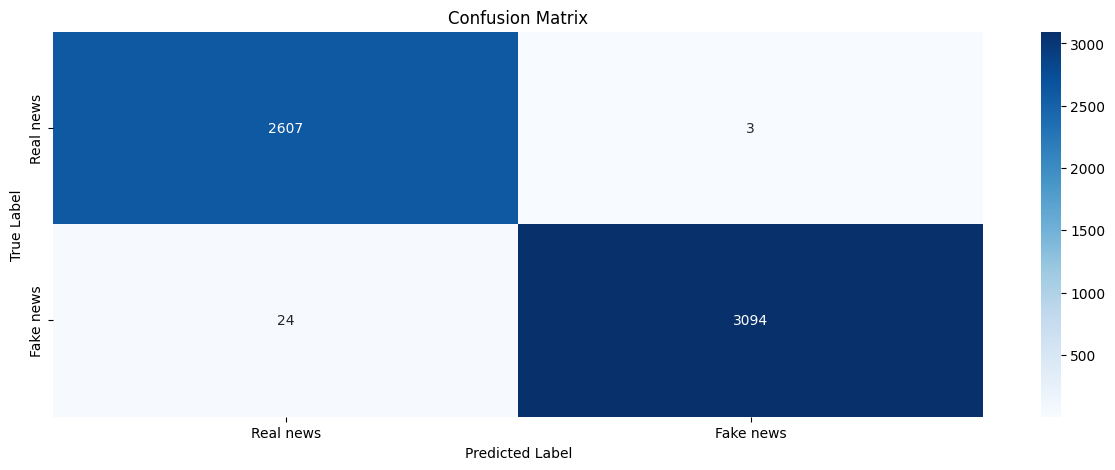

In [ ]:
plt.figure(figsize=(15, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real news', 'Fake news'], yticklabels=['Real news', 'Fake news'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Summary

After running the model for 3 epochs, we observed that it was making accurate predictions, which could indicate overfitting. In the next experiment, we will examine some of the model's predictions to gain a better understanding of its performance and behavior.